In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import copy as cp
import pandas as pd
import countryinfo
import geopandas as gpd
from timeit import default_timer as timer # try to measure time
from climada.engine import Impact
from climada.entity import ImpactFunc,ImpactFuncSet
import cartopy.crs as ccrs
from os import mkdir, remove, rmdir


In [2]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

# Exposure

In [4]:
#import exposure data (already preprocessed)
from climada.entity import Exposures
from climada import CONFIG
results = CONFIG.local_data.save_dir.dir()
exp = Exposures.from_hdf5(results.joinpath(('exposures/exp_crpd_EU_600.h5')))
exp.check()


/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'LitPop Exposure for Europe, 2018\nProduced capital')

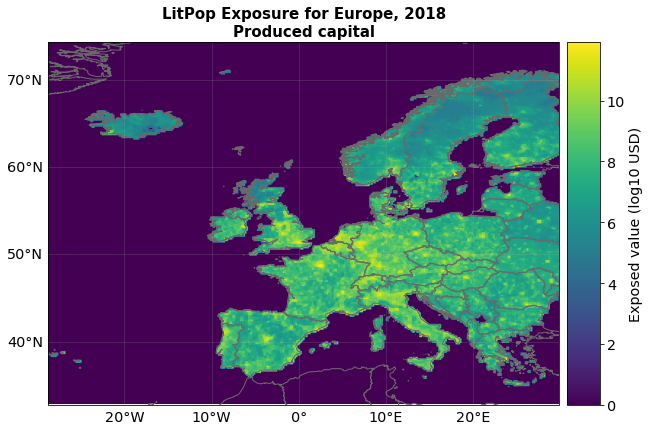

In [5]:
#ax = exp.plot_hexbin(pop_name=False,vmin=1E7,vmax=1E11
ax = exp.plot_raster(label='Exposed value (log10 USD)')

ax.set_title('LitPop Exposure for Europe, 2018\nProduced capital',fontsize=15,fontweight="bold")
#plt.savefig(savefigpath+'/Exposures/hexbin_exp_cropped600EU.png',transparent=False)

# Impact functions
1) Import sigmoid from Emanuel
2) Import empirical from Schwierz
3) Construct Cubic EOT (same intensity scale as Schwierz)

In [12]:
#chose impf type
impf_set_name = 'abs_impfset.csv' #impf working with absolute value 
pp_func_dic = pp_func_dic_mask
#load impfset
impf_set_uncal = ImpactFuncSet()
impf_set_uncal.read_excel(pathin+'impf/'+impf_set_name)
pp_func_dic = pp_func_dic # ! chose the correct pp_func_dic
impf_dict = {}
impf_set_dict = {}
impf_namelist = []
for ifid, impf in impf_set_uncal.get_func()['WS'].items():
    impf_name = impf.name
    impf_namelist.append(impf_name)
    impf_dict[impf_name] = [ifid,impf]
    new_impfset = ImpactFuncSet()
    new_impf = cp.deepcopy(impf)
    new_impf.id = 0 
    new_impfset.append(new_impf)
    impf_set_dict[impf_name] = new_impfset


2022-10-31 14:36:44,820 - climada.entity.impact_funcs.impact_func_set - WARNING - The use of ImpactFuncSet.read_excel is deprecated.Use ImpactFuncSet.from_excel instead.
2022-10-31 14:36:44,837 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-10-31 14:36:44,838 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-10-31 14:36:44,838 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


array([<AxesSubplot:title={'center':'WS 1: Cubic excess-over-threshold'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 2: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 3: Schwierz 2010'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>],
      dtype=object)

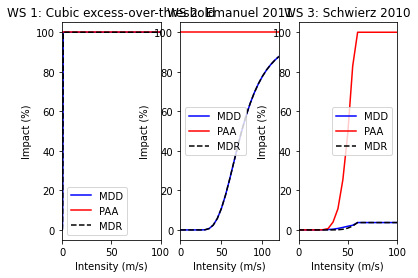

In [7]:
impf_set_uncal.plot()

# Main calculation cell
Use stack=True to stack model members on top of each other, set stack=False to consider each member separately.
Use savehaz, saveimpcsv, saveimpmat to save hazards or/and imapcts.
1) Loop over impact functions
2) Loop over scenarios
3) Loop over climate models
4) Loop over model members


In [20]:
impf_namelist

['Cubic excess-over-threshold', 'Emanuel 2011', 'Schwierz 2010']

In [37]:
#select climate models, used scenarios (historical, ssp585,...), impact functions and calibration type

#ncdf
pathinera5 = '/home/lseverino/MT/era5/'
impf_used = impf_namelist
eravar = "WG10"
spaceres = "br"
timeres = "day"
domain = "EU"
season = "winE"
modname = "era5"
era_bn = "_".join([modname,eravar,spaceres,timeres,domain,season])
modlist = [modname]
pastname = 'historical'
timeres='day'
caltype = 'nocal'
savesubdir = 'era5/'

#preprocessing 
gst_fact = 1
qt = 0.98
cut=5E5
mask_abs = 15

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","mask_abs"+format(mask_abs,'.0f'),"cutarea"+format(cut,'.0E').replace("+0",''),"gst"+format(gst_fact,'.2f').replace(".",'-')]
era_bn_proc = make_fn(processings,era_bn) 

In [38]:
era_bn_proc

'qt98pst_mask_abs15_cutarea5E5_gst1-00_era5_WG10_br_day_EU_winE'

In [34]:
#initiate df to save results
metrics = ['aai_agg',1,10]
metnames = ["AAI_agg", str(1)+'yr RPI',str(10)+'yr RPI']
cutidx = ["cutarea"+format(cut,'.0E').replace("+0",'') for cut in cuts]
res_df = pd.DataFrame(columns=metnames,index=cutidx)


In [39]:
##main calculation cell.
#Loop over impact functions, scenarios, models and model members
#Use stack=True to stack model members on top of each other, set stack=False to consider each member separately.
#Use savehaz, saveimpcsv, saveimpmat to save hazards or/and imapcts.
savehaz = False
saveimpmat = False
saveimpcsv = False
savestats = True
regrid = True
rg_res = 1
if_id = 0
it = 0 #iteration count
df_list = []
impf_keys = []    


#get era5 
fnera5 =era_bn+'.nc'
era_ds = xr.open_dataset(pathinera5+fnera5)
era_ds = era_ds.rename_dims(time=timeres)
era_ds = era_ds.rename_vars({eravar:pastname})

#era_da = era_ds['sfcWindmax']
latres, lonres = get_lat_lon_res(era_ds)
latin = era_ds.lat
lonin = era_ds.lon
#preprocess
gust_era = gst_fact*era_ds

if regrid: #regrid era5
    latout = np.arange(min_lat,max_lat+rg_res,rg_res)
    lonout = np.arange(min_lon,max_lon+rg_res,rg_res)
    gust_era = gust_era.interp(lat=latout,lon=lonout, method='linear',kwargs={"fill_value": 'extrapolate'})
    
for impf in impf_used:
    
    # get impfset
    impf_set = impf_set_dict[impf]
    preprocess_func = pp_func_dic[impf]
    impf_namesht = impf_sht_names[impf]
    pp_funcname = str(pp_func_dic[impf]).split(" ")[1]
            
    for cut in cuts:
        gust_pp = preprocess_func(gust_era,qt,mask_abs=mask_abs,cutarea=cut,timeres=timeres,pastname=pastname,futname=pastname,stack=False)
        
        #prepare hazards centroids
        haz = set_centroids(gust_pp,stack=False,timeres=timeres,plot=False)
        if impf_namesht == 'CubEOT':
            max_int =  haz.intensity.max()
            if max_int >= 1:
                print("*"*100+'\n\n'+' '*25+'/!\ max_int = '+str(max_int)+' for model '+modname+'\n\n'+"*"*100)
            
            
        # deepcopy exposure before assigning centroids
        exp_sel = cp.deepcopy(exp)
        # Exposures: rename column and assign id
        exp_sel.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
        exp_sel.gdf['impf_' + haz_type] = if_id
        
        ####### dummy exposure
        #exp_sel.gdf.value = 1000
        #test = 'stepexp' # step exposure
        #assign centroids
        #exp_sel.assign_centroids(haz,distance='approx',threshold=300)
        dist_th = np.sqrt((latres*100)**2 + (lonres*100)**2)
        exp_sel.assign_centroids(haz,distance='euclidean',threshold=dist_th)
        exp_sel.check()
        
        #compute impacts
        #past
        start_time = timer()
        imp = Impact()
        imp.calc(exp_sel, impf_set, haz, save_mat=saveimpmat) #Do not save the results geographically resolved (only aggregate values)
        time_delta_past = timer() - start_time
        print(time_delta_past)
        #save results
        if savestats:
            for imet,met in enumerate(metrics):
                if met=='aai_agg':
                    impmet = imp.aai_agg
                else:
                    impmet = imp.calc_freq_curve(return_per=met).impact 

                res_df.loc["cutarea"+format(cut,'.0E').replace("+0",''),metnames[imet]] = impmet

            
    
        ##save files
        # get names
        
        savenamehaz = make_fn([pp_funcname],era_bn)
        savenameimp = make_fn([impf_namesht,caltype],bn_proc)
        #save hazards
        if savehaz:
            try:
                haz.write_hdf5(pathhaz+savesubdir+make_fn(['haz',scen,modname],savenamehaz,filetype='.h5'))
            except FileNotFoundError:
                mkdir(pathhaz+savesubdir)
                haz.write_hdf5(pathhaz+savesubdir+make_fn(['haz',scen,modname],savenamehaz,filetype='.h5'))
        #save impacts
        if saveimpcsv:
            try:
                #rmdir(pathimp+'impact csv/memsep/'+scen+"/")
                #mkdir(pathimp+'impact csv/memsep/'+scen+"/")
                imp.write_csv(pathimp+'impact csv/aggregated/'+savesubdir+make_fn(['imp',modname],savenameimp,filetype='.csv'))
            except FileNotFoundError:
                mkdir(pathimp+'impact csv/aggregated/'+savesubdir)
                imp.write_csv(pathimp+'impact csv/aggregated/'+savesubdir+make_fn(['imp',modname],savenameimp,filetype='.csv'))
        if saveimpmat:
            try:
                #rmdir(pathimp+'impact matrices/'+savesubdir)
                #mkdir(pathimp+'impact matrices/'+savesubdir)
                imp.write_sparse_csr(pathimp+'impact matrices/aggregated/'+savesubdir+make_fn(['imp',modname],savenameimp,filetype='.npz'))
            except FileNotFoundError:
                mkdir(pathimp+'impact matrices/aggregated/'+savesubdir)
                imp.write_sparse_csr(pathimp+'impact matrices/aggregated/'+savesubdir+make_fn(['imp',modname],savenameimp,filetype='.npz'))
        #delete haz, imp and ep  objects
        del haz
        del imp
        del exp_sel
        it = it+1       
    
    res_df = res_df.astype(np.float64)
    impf_keys.append(impf_namesht)
    df_list.append(res_df)

res_df_all = pd.concat(df_list,keys=impf_keys,axis=1,names=("Impf","metric"))

TypeError: scale_qt() got an unexpected keyword argument 'mask_abs'

In [26]:
pathimp+'impact matrices/aggregated/'+savesubdir+make_fn(['imp',modname],savenameimp,filetype='.npz')

'/home/lseverino/MT/scripts/results/impacts/impact matrices/aggregated/era5/imp_era5_Sw2010_nocal_qt98pst_cutarea5E5_gst1-67_SWM_br_day_EU_winE.npz'

In [25]:
res_df_all

Impf              CubEOT                                    Em2011  \
metric           AAI_agg       1yr RPI      10yr RPI       AAI_agg   
cutarea5E5  9.407617e+10  1.791622e+10  1.280994e+11  1.941759e+09   

Impf                                          Sw2010                \
metric           1yr RPI      10yr RPI       AAI_agg       1yr RPI   
cutarea5E5  3.218019e+08  2.609189e+09  1.941759e+09  3.218019e+08   

Impf                      
metric          10yr RPI  
cutarea5E5  2.609189e+09

## Plots

/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/home/lseverino/climada_python/climada/entity/exposures/base.py:702: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


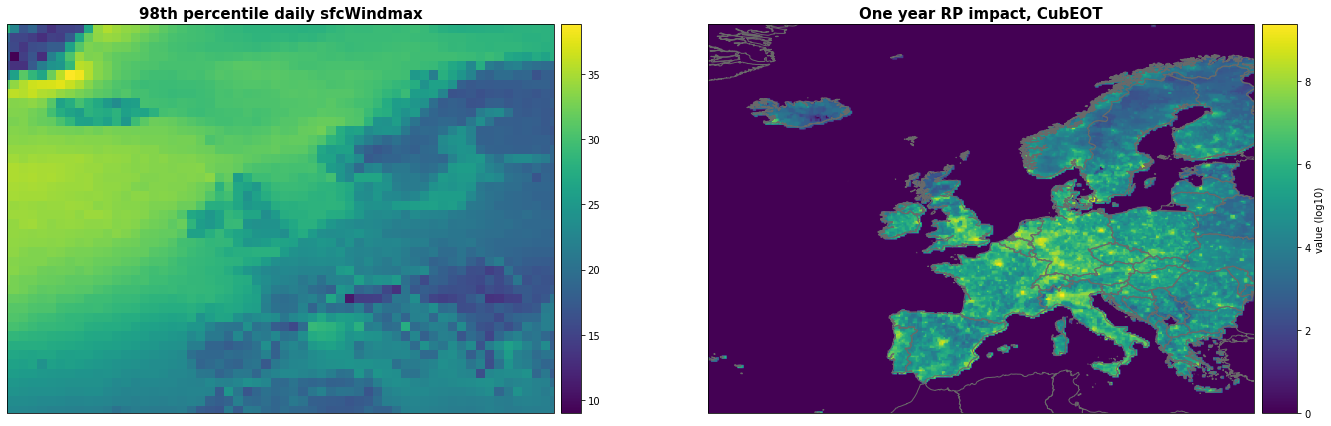

In [66]:
#stats
met = 1
impfname = "CubEOT"

##filenames
impcsvfn =pathimp+'impact csv/aggregated/era5/imp_era5_'+impfname+'_nocal_qt98pst_cutarea5E5_gst1-67_SWM_br_rg_day_EU_winE.csv'
impmatfn =pathimp+'impact matrices/aggregated/era5/imp_era5_'+impfname+'_nocal_qt98pst_cutarea5E5_gst1-67_SWM_br_rg_day_EU_winE.npz'
## open impacts
#past
imp = Impact()
imp = imp.from_csv(impcsvfn)
imp_met = cp.deepcopy(imp)
imp.imp_mat = imp.read_sparse_csr(impmatfn)
imp_mat = imp.local_exceedance_imp(return_periods=[met])
imp_mat = imp_mat.reshape((imp_mat.shape[1],))
imp_met.eai_exp = imp_mat

#plot
savefig = False
savelocation= pathfig+"/Impacts/Impact maps/"
savefileName= "era5_98qt_imp_rp1_"+impfname+"_nocal_qt98pst_cutarea5E5_gst1-67_SWM_br_rg_day_EU_winE"
color = "viridis"
ncols = 2
nrows = 1
fig = plt.figure(constrained_layout=True,figsize=(10*ncols,6*nrows))
#fig.suptitle(maintitle,fontsize=mainttsize,fontweight="bold",y=1.002)
#axs = fig.subplots(nrows=nmods+1, ncols=len(fieldnames),sharex=False,sharey=False ,gridspec_kw=gridspec,subplot_kw={'projection': ccrs.PlateCarree()})
axs = fig.subplots(nrows=nrows, ncols=ncols,sharex=True,sharey=True ,subplot_kw={'projection': ccrs.PlateCarree()})
gust_era_qt = gust_era.historical.quantile(0.98,dim="day")
h = gust_era_qt.plot(ax=axs[0],extend='both',cmap=color,add_colorbar=False)
imp_met.plot_raster_eai_exposure(axis=axs[1])
cbw = fig.colorbar( h,ax=axs[0],orientation='vertical',extendrect=True,shrink=1, pad=0.01)
axs[0].set_title("98th percentile daily sfcWindmax",fontweight="bold",fontsize=15)
axs[1].set_title("One year RP impact, "+impfname,fontweight="bold",fontsize=15)
if savefig:
    fig.savefig(savelocation+savefileName,transparent=False,bbox_inches='tight')



## Compare with EMDAT


In [54]:
#read EMDAT data
ETC_data = pd.read_excel('../inputdata/impacts/emdat_EU_1960_2022_ETC.xlsx',header=6)

# keep only useful data
keep = ['Dis No','Event Name','Seq', 'Year','Country','Region','Dis Mag Value','Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month',
       'End Day', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless',
       'Total Affected', 'Reconstruction Costs (\'000 US$)',
       'Insured Damages (\'000 US$)', 'Total Damages (\'000 US$)','Total Damages, Adjusted (\'000 US$)']
ETC_small = ETC_data[keep]

#cut below 2011
ETC_small = ETC_small.where(ETC_small['Start Year']<2010).dropna(how='all',axis=0)

#build time index
dft_start = pd.DataFrame(

    {"year": ETC_small['Start Year'], "month": ETC_small['Start Month'], "day": ETC_small['Start Day']}

)
dft_end = pd.DataFrame(

    {"year": ETC_small['End Year'], "month": ETC_small['End Month'], "day": ETC_small['End Day']}

)
dti_start = pd.to_datetime(dft_start)
dti_end= pd.to_datetime(dft_end)

# resample to daily
ETC_dmg = ETC_small
ETC_dmg.index = dti_start

#select events which had an impact of more than 100 mnUSD
ETC_dmg_100mn = ETC_dmg.where(ETC_dmg['Total Damages, Adjusted (\'000 US$)']>= 1E5)

#drop nana
ETC_dmg_nona = ETC_dmg_100mn.dropna(how='all')

#take unique days
EMDAT_days = ETC_dmg_nona.index.unique()


/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [55]:
strm_idx = ETC_small['Event Name'].unique()

In [56]:
strm_idx = ETC_dmg_nona['Event Name'].unique()
storm_days_dict = dict()
for stormname, group in ETC_dmg_nona.groupby('Event Name'):
    
    #dft_start = '-'.join([format(group['Start Year'].min(),'.0f'),format(group['Start Month'].min(),'.0f'),format(group['Start Day'].min(),'.0f')])
    #dft_end = '-'.join([format(group['End Year'].max(),'.0f'),format(group['End Month'].max(),'.0f'),format(group['End Day'].max(),'.0f')])

    dft_start = pd.DataFrame({"year": group['Start Year'].min(), "month": group['Start Month'].min(), "day": group['Start Day'].min()},index=['start'])
    dft_end = pd.DataFrame({"year": group['End Year'].max(), "month": group['End Month'].max(), "day": group['End Day'].max()},index=['end'])
    dti_start = pd.to_datetime(dft_start,format='YYYY-MM-DD')
    dti_end= pd.to_datetime(dft_end,format='YYYY-MM-DD')
    storm_time_idx = pd.date_range(start=dti_start[0],end=dti_end[0])

    storm_days_dict[stormname] = storm_time_idx

In [57]:
storm_days_dict

{'Anatol': DatetimeIndex(['1999-12-03', '1999-12-04', '1999-12-05'], dtype='datetime64[ns]', freq='D'),
 'Calvann': DatetimeIndex(['2003-01-02'], dtype='datetime64[ns]', freq='D'),
 'Cilly, Desiree, Fanny': DatetimeIndex(['1998-01-01', '1998-01-02', '1998-01-03', '1998-01-04',
                '1998-01-05', '1998-01-06'],
               dtype='datetime64[ns]', freq='D'),
 'Cilly, Désirée et Fanny': DatetimeIndex(['1998-01-01', '1998-01-02', '1998-01-03', '1998-01-04',
                '1998-01-05', '1998-01-06'],
               dtype='datetime64[ns]', freq='D'),
 'Emma': DatetimeIndex(['2008-02-29', '2008-03-01', '2008-03-02'], dtype='datetime64[ns]', freq='D'),
 'Erwin': DatetimeIndex(['2005-01-07', '2005-01-08', '2005-01-09', '2005-01-10',
                '2005-01-11', '2005-01-12', '2005-01-13'],
               dtype='datetime64[ns]', freq='D'),
 'Jeanett': DatetimeIndex(['2002-10-26', '2002-10-27', '2002-10-28'], dtype='datetime64[ns]', freq='D'),
 'Jeannet': DatetimeIndex(['2002-10-

In [58]:
#delete storms present twice
del storm_days_dict['Jeannet']
del storm_days_dict['Cilly, Désirée et Fanny']

In [63]:
#select era5 data
cut = 5E5
gust_pp = preprocess_func(gust_era,qt,cutarea=cut,timeres=timeres,pastname=pastname,futname=pastname,stack=False)
era5_sel = gust_pp.isel(day=gust_pp.time.dt.year.isin(range(1998,2011)))


#to pandas datetime
tformat = 'YYYY-MM-DD'
era5_days = pd.to_datetime(era5_sel.time.values,format=tformat)
EMDAT_days =  pd.to_datetime(EMDAT_days,format=tformat)

#create dataframe
dayid = pd.date_range(start=era5_days[0],end=era5_days[-1],freq='1D')
event_df = pd.DataFrame({'Event':False,'Detected':False,'Hits':False,'Misses':False,'False alarms':False,'Correct neg':False,'Storm Name':np.nan},index=dayid)

#detected
event_df.loc[era5_days,'Detected'] = True


#events 
#event_df.loc[EMDAT_days,'Event'] = True
for stormname,stormdays in storm_days_dict.items():
    event_df.loc[stormdays,'Event'] = True
    event_df.loc[stormdays,'Storm Name'] = stormname

#drop nans

#hits
#mask_hits = np.in1d(era5_days, EMDAT_days)
#hits = era5_days[mask_hits]
rowidhi = event_df[(event_df['Event']==True) & (event_df['Detected']==True)].index
event_df.loc[rowidhi,'Hits'] = True

#missed
rowidmi = event_df[(event_df['Event']==True) & (event_df['Detected']==False)].index
event_df.loc[rowidmi,'Misses'] = True

#False alarm
rowidfa = event_df[(event_df['Event']==False) & (event_df['Detected']==True)].index
event_df.loc[rowidfa,'False alarms'] = True

#Correct negatives
rowidcn = event_df[(event_df['Event']==False) & (event_df['Detected']==False)].index
event_df.loc[rowidcn,'Correct neg'] = True

#remove useless rows
#event_df = event_df[(event_df['Event'] == True) | (event_df['Detected'] == True)]

In [64]:
era5_days

DatetimeIndex(['1998-01-01', '1998-01-02', '1998-01-03', '1998-01-04',
               '1998-01-05', '1998-01-06', '1998-01-09', '1998-01-12',
               '1998-01-13', '1998-01-18',
               ...
               '2009-12-22', '2009-12-23', '2009-12-24', '2009-12-25',
               '2009-12-26', '2009-12-27', '2009-12-28', '2009-12-29',
               '2009-12-30', '2009-12-31'],
              dtype='datetime64[ns]', length=813, freq=None)

In [75]:
np.sum(event_df['False alarms']==True)

782

In [66]:
#Missed events
event_df.where(event_df["Misses"]==True).dropna(how='all',axis=0)

,Event,Detected,Hits,Misses,False alarms,Correct neg,Storm Name
1999-12-05,True,False,False,True,False,False,Anatol
2005-01-13,True,False,False,True,False,False,Erwin
2007-01-17,True,False,False,True,False,False,Kyrill
2009-01-26,True,False,False,True,False,False,Klaus


In [74]:
4/35

0.11428571428571428

In [67]:
#construct base rate, hit rate and false alarm rate
score_df = pd.DataFrame(columns=['base rate','hit rate', 'false alarm rate'],index=modlist)
score_df.loc[modname,'base rate'] = event_df['Event'].sum()/len(dayid)
score_df.loc[modname,'hit rate'] = event_df['Hits'].sum()/(event_df['Hits'].sum()+event_df['Misses'].sum())
score_df.loc[modname,'false alarm rate'] = event_df['False alarms'].sum()/(event_df['False alarms'].sum()+event_df['Correct neg'].sum())




In [68]:
score_df
score_df.style.format('{:.2}')

,base rate,hit rate,false alarm rate
era5,0.008,0.89,0.18


In [44]:
event_df.sum()

/tmp/ipykernel_38415/2631713552.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  event_df.sum()


Event             35
Detected         813
Hits              31
Misses             4
False alarms     782
Correct neg     3566
dtype: int64